In [1]:
import pandas as pd
import numpy as np
import string
import nltk
import re
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import CountVectorizer
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import string
from transformers import BertTokenizer, BertModel
import torch
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle
import re

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#warnings.filterwarnings("ignore", category=UserWarning) 

In [20]:
dfs = []

df_jersey = pd.read_csv('car_data_sorted-NewJersey_.csv')
df_jersey['Price'] = pd.to_numeric(df_jersey['Price'], errors='coerce')
df_jersey = df_jersey[df_jersey['Price'] <= 1000000]
df_jersey = df_jersey.reset_index(drop=True)
df_jersey['Price'] = df_jersey['Price'].astype(int)

files = ['car_data_sorted-Boston_.csv','car_data_sorted-Chicago_.csv','car_data_sorted-Minneapolis_.csv',\
        'car_data_sorted-NY_.csv', 'car_data_sorted-Inlandempire_.csv', 'car_data_sorted-Miami_.csv',\
        'car_data_sorted-Denver_.csv','car_data_sorted-Dallas_.csv','car_data_sorted-Phoenix_.csv',\
         'car_data_sorted-Portland_.csv','car_data_sorted-SanDiego_.csv','car_data_sorted-LA_.csv', \
         'car_data_sorted-SF_.csv', 'car_data_sorted-Seattle_.csv', 'car_data_sorted-OrangeCounty_.csv',\
         'car_data_sorted-Sacramento_.csv','car_data_sorted-Tampa_.csv','car_data_sorted-Atlanta_.csv',\
         'car_data_sorted-Austin_.csv','car_data_sorted-Detroit_.csv','car_data_sorted-Houston_.csv',\
         'car_data_sorted-LasVegas_.csv']
for file in files:   
    df = pd.read_csv(file)
    df = df.replace('',np.nan,regex = True)
    dfs.append(df)
    
dfs.append(df_jersey)

print("Length of 'raw' dataframe: ", len(df))    
df = pd.concat(dfs, axis = 0,sort=True).reset_index(drop = True)
df.drop_duplicates(inplace = True)
df = df.drop_duplicates(subset='Description')
# Reset the index
df = df.reset_index(drop=True)

print('First length of unrefined df: ', len(df))
#df.to_csv('full_df_text.csv')

# Drop and Impute NaNs
unfilled_cars = []
cnt = 0
cnt1 = 0
cnt2 = 0

df = df.loc[(df['Year'] != 0) & (df['Make'] != 0) & (df['Model'] != 0) & (df['Model'] != '0')].reset_index()

# Model adjustments
for i in range(len(df)):
    if (len(df.loc[i,'Model']) == 4 and df.loc[i,'Model'].isdigit())\
    or (df.loc[i,'Model'] == 'Pickup'): # or len(df.loc[i,'Model']) == 1
        df.loc[i,'Model'] = ''
    if (df.loc[i,'Make'] == 'Honda' and df.loc[i,'Model'] == 'Cr'):
        df.loc[i,'Model'] = 'Crv'
    if df.loc[i,'Make'] == 'Alpha':
        df.loc[i,'Make'] = ''
    if df.loc[i,'Make'] == 'Mustang':
        df.loc[i,'Make'] = 'Ford'
        df.loc[i,'Model'] = 'Mustang'
    if (df.loc[i,'Make'] == 'Tesla' and df.loc[i,'Model'] == 'X'):
        df.loc[i,'Model'] = 'Model X'
    if (df.loc[i,'Make'] == 'Tesla' and df.loc[i,'Model'] == 'S'):
        df.loc[i,'Model'] = 'Model S'
    if (df.loc[i,'Make'] == 'Tesla' and df.loc[i,'Model'] == 'Y'):
        df.loc[i,'Model'] = 'Model Y'
    if (df.loc[i,'Make'] == 'Tesla' and df.loc[i,'Model'] == 'M3'):
        df.loc[i,'Model'] = 'Model 3'
    if (df.loc[i,'Make'] == 'Tesla' and df.loc[i,'Model'] == '3'):
        df.loc[i,'Model'] = 'Model 3'

df = df.drop(columns = ['index'])
df1 = df.loc[:,['Make','Model','Cylinders','Drive']]
df_models2 = pd.read_csv('vehicle_models_updated.csv')
df_models21 = df_models2.loc[:,['Make','Model','Cylinders','Drive']]
df_merged = df1.merge(df_models21, how = 'left', on = ['Make','Model'])
df_first1 = df_merged.loc[:,('Make','Model','Cylinders_x', 'Drive_x')].rename(columns={"Cylinders_x": "Cylinders", "Drive_x": "Drive"})
df_models1 = df_merged.loc[:,('Make','Model','Cylinders_y', 'Drive_y')].rename(columns={"Cylinders_y": "Cylinders", "Drive_y": "Drive"})
df_first1 = df_first1[['Cylinders', 'Drive', 'Make', 'Model']]
df_first1 = df_first1.combine_first(df_models1)

df.loc[:,['Cylinders','Drive','Make','Model']] = df_first1

for i in range(len(df)):
    if df.loc[i,'Make'] == 'Tesla':
        df.loc[i,'Fuel'] = 'Electric'
        df.loc[i,'Transmission'] = 'Automatic'
    if (df.loc[i,'Make'] == 'Tesla' or df.loc[i,'Fuel'] == 'Electric'):
        df.loc[i,'Cylinders'] = '0'

for i in range(1,len(df)):
    if not isinstance(df.loc[i,'Color'], str):
        cnt +=1
        df_t = df[(df['Make'] == df.loc[i,['Make']][0]) & (df['Model'] == df.loc[i,['Model']][0])]['Color']
        df_t = df_t[~df_t.isna()]
        try:
            if len(df_t) >= 5:
                cnt1 +=1
                df.loc[i,'Color'] = df_t.mode()[:1][0]
            else:
                raise Exception('Too short')
        except Exception as e: 
                cnt2 +=1
                unfilled_cars.append(str(df.loc[i,['Make']][0])+' '+str(df.loc[i,['Model']][0]))
                pass      

# Price, Odometer, and Year Filters     
print(df.isnull().sum())
df = df.dropna(axis=0)
df.reset_index(drop = True, inplace = True)

#df = pd.concat([df,df_large], axis = 0,sort=True).reset_index(drop = True)

df_m = df

Length of 'raw' dataframe:  1402
First length of unrefined df:  58190
Color           1185
Condition          0
Cylinders       2442
Description        1
Drive           3391
Fuel               0
Make               0
Model              0
Odometer           0
Price              0
Title Status       0
Transmission       0
Year               0
dtype: int64


In [3]:
df_m.to_csv('df_latest.csv')

In [21]:
df = df_m

# df.drop(index = 43697,inplace = True)
# df.reset_index(inplace = True)
# df.loc[df['Price'].apply(lambda x: isinstance(x, str)), 'Price'] = df['Price'].astype(int)

# create lower price filter
q_low1 = 900
q_low2 = 1983
# create upper price filter
###########################
q_hi1  = df.Price.quantile(0.98)
#print("High price cutoff: ", q_hi1)
q_hi2  = 350000
q_hi3  = 2024
# filter the data frome
df = df[(df["Price"] < q_hi1) & (df["Price"] > q_low1) & (df["Odometer"] < q_hi2) & (df["Year"] > q_low2) & (df["Year"] < q_hi3)]
df = df[df['Description'].apply(len) <= 1200]
df.reset_index(drop = True, inplace = True)
print('Fourth length of final df: ', len(df))

# Drop NaN        
df = df.replace('',np.nan,regex = True)
df = df.dropna(axis=0)
df.reset_index(drop = True, inplace = True)
print('Length of df: ', len(df))

#df.drop_duplicates(inplace = True)
df_temp = df.groupby(['Make','Model']).size().to_frame().rename(columns = {0: 'count'})
######################################################
df_temp = df_temp[df_temp['count'] >= 17].reset_index()
#df = df.groupby('Make').filter(lambda x : len(x)>19)

df['car'] = ['' for i in range(len(df))]
df.loc[:,('car')] = df["Make"].astype(str) + " " + df["Model"].astype(str)
# df_models2['car'] = df_models2[["Make", "Model"]].apply(" ".join, axis=1)
df_temp['vehicle'] = ['' for i in range(len(df_temp))]
df_temp.loc[:,('vehicle')] = df_temp["Make"].astype(str) + " " + df_temp["Model"].astype(str)
print(len(df))
df = df[df['car'].isin(df_temp['vehicle'])]
print(len(df))
df = df.drop('car', axis = 1)
df = df.reset_index(drop = True)
print(len(df))
#df.drop('index', axis = 1, inplace = True)
print('Final length of final df: ', len(df))

#df = df.dropna(axis=0)
df['Cylinders'] = pd.to_numeric(df['Cylinders']).astype(int)
df['Odometer'] = pd.to_numeric(df['Odometer']).astype(int)
df['Price'] = pd.to_numeric(df['Price']).astype(int)
df['Year'] = pd.to_numeric(df['Year']).astype(int)

df.rename(columns = {'Title Status': 'Title'}, inplace = True)
#Feature Engineering
#df['Condition'].replace({'New': 'Excellent', 'Like New': 'Excellent', 'Fair': 'Good', 'Salvage': "Good"}, inplace = True)
df['Transmission'].replace({'Automatic': 1, 'Manual': 0, 'Other': 0}, inplace = True)
df.rename(columns = {'Transmission': 'Transmission_Automatic'}, inplace = True)
df = df.dropna(axis=0)
df['Description'] = df['Description'].str.lower()
df['Description'] = df['Description'].apply(lambda x: x if x.endswith('.') else x + '.')

punctuation_to_remove = '*#$/|~%<>@'

df['Description'] = df['Description'].apply(lambda x: x.translate(str.maketrans('', '', punctuation_to_remove)) if pd.notnull(x) else x)

prepositions = [
                                "aboard", "about", "above", "across", "after", "against", "along", "amid", 
                                "among", "around", "as", "at", "before", "behind", "below", "beneath", 
                                "beside", "between", "beyond", "but", "by", "concerning", "considering", 
                                "despite", "down", "during", "except", "for", "from", "in", "inside", 
                                "into", "like", "near", "of", "off", "on", "onto", "out", "outside", 
                                "over", "past", "regarding", "round", "since", "through", "to", "toward", 
                                "under", "underneath", "until", "unto", "up", "upon", "with", "within", "without"
                              ]


car_makes_models = df.Make.unique().tolist() + df.Model.unique().tolist()
car_makes_models = [cmm.lower() for cmm in car_makes_models]
filter_words = stopwords.words('english') + prepositions + ['i', 'my', 'me',"i'm", "i'll", 'awesome', "i've"] + car_makes_models
translator = str.maketrans('', '', string.punctuation)

def preprocess(text):
    text = text.lower()
    text = text.translate(translator)
    words = text.split()
    words = [word for word in words if word not in filter_words and len(word) > 1 and not (len(word) == 4 and word.isdigit())\
            and not (len(word) == 2 and word.isdigit())]     
    return words

words = [word for description in df['Description'] for word in preprocess(description)]

word_counts = Counter(words)
####################################################################
#top_500_words = [word for word, freq in word_counts.most_common(500)]
top_200_words = [word for word, freq in word_counts.most_common(180)] #180
top_200_words = set(top_200_words)
pattern = '|'.join('\\b'+word+'\\b' for word in top_200_words)

def filter_sentences_optimized(description):
    sentences = re.split(r'(?<=[.!?,])\s+', description)
    filtered_sentences = []

    for sentence in sentences:
        if "serious inquiries" in sentence.lower() or "serious inquires" in sentence.lower():
            continue
        sentence_words = re.findall(r'\b[\w\'@]+\b', sentence)
        top_200_count = sum(word in top_200_words for word in sentence_words)       
        # Fix specific contractions without apostrophes
        sentence = re.sub(r"\bi ve\b", "i've", sentence)
        sentence = re.sub(r"\bi m\b", "i'm", sentence)   
        sentence = re.sub(r"\bdon t\b", "don't", sentence)
        sentence = re.sub(r"\bwon t\b", "won't", sentence)
        sentence = re.sub(r"\bcan t\b", "can't", sentence)
        sentence = re.sub(r"\blet s\b", "let's", sentence)
        sentence = re.sub(r"\doesn t\b", "doesn't", sentence)
        sentence = re.sub(r"\bit s\b", "it's", sentence)
        sentence = re.sub(r"\bisn t\b", "isn't", sentence)
        sentence = re.sub(r"\bhere s\b", "here is", sentence)
        sentence = re.sub(r"\bthere s\b", "there is", sentence)
        #sentence = re.sub(r"(?<!\d)\.|\.(?!\d)", ".", sentence)
        #sentence = re.sub(r"\.\s*\.", ".", sentence) 
        unwanted_words = ['call', 'text', 'at', 'me', 'contact', '@', 'txt', 'email','please','calltext', 'emails'\
                         ,'texts','inquiries','offers','offer','cash','trade','trades','scammmer','price','firm','time',\
                         'waste','sell','i','negotiate','opportunity',"i've","i'm","i'll","i'd","we",'you',"you'll",\
                         'love','contact','question','questions','interested','message','information','phone',\
                         'ask'] + car_makes_models
        if not any(char.isdigit() for char in sentence) and \
        sum(word in sentence_words for word in unwanted_words) < 2\
           and 2 <= len(sentence_words) <= 20 and top_200_count >= 1:
            
            filtered_sentences.append(sentence)
            
    return ''.join(filtered_sentences)

def remove_parentheses(text):
    # Define the pattern to match parentheses and their contents
    pattern = r"\([^()]*\)"    
    # Use the sub() function from the re module to replace the pattern with an empty string
    cleaned_text = re.sub(pattern, '', text)    
    return cleaned_text
# def replace_trailing_comma(text):
#     import re

def fix_text(text):
    # Remove leading/trailing whitespace
    text = text.strip()
    # Replace any whitespace before a period with nothing
    text = re.sub(r'\s+([.])', r'\1', text)
    # If the text ends with a comma, replace the last character (comma) with a period
    if text.endswith(','):
        text = text[:-1] + '.'
    # Replace two or more consecutive periods or a mix of periods and commas at the end with a single period
    text = re.sub(r'([.,]{2,})$', '.', text)
    # Replace two or more consecutive periods anywhere in the text with a single period
    text = re.sub(r'\.{2,}', '.', text)
    
    return text



df['Description'] = df['Description'].str.replace(';', '.')
#df['Description'] = df['Description'].str.replace(',', '.')
df['Description'] = df['Description'].apply(remove_parentheses)
#print(df['Description'][0], '---3')
#print('==========================')
#df['Description'] = df['Description'].str.replace(r'\d+', '')
# Remove extra spaces
df['Description'] = df['Description'].str.replace(r'\s+', ' ', regex=True)
# Replace '&' with 'and'
df['Description'] = df['Description'].str.replace('&', 'and')
df['Description'] = df['Description'].str.replace(r'[?!]', '.', regex=True)

df_old = df[:1000]

# # Define the letters to be removed
# pattern = r'\b[k]\b'  # Replace 'abc' with the specific letters you want to remove

# # Apply the pattern and replace with an empty string
# df['Description'] = df['Description'].str.replace(pattern, '', regex=True)
#features_cat = ["Make", "Color", "Drive",'Fuel', 'Title Status']

df['Description'] = df['Description'].apply(filter_sentences_optimized)
#df['Description'] = df['Description'].str.replace(',', ' ')

#df['Description'] = df['Description'].str.replace('.', ' ')
df['Description'] = df['Description'].astype(str)

df['Description'] = df['Description'].apply(fix_text)

features_cat_basic = ["Make", "Model", "Drive", 'Fuel', 'Title', 'Color','Cylinders', 'Condition']
#price dataframe
df_price = df[['Price']]
df_num = df[["Year",'Odometer']]
df_num_price = pd.concat([df_num, df_price], axis = 1,sort=True)
df_cat_basic = df[features_cat_basic]
df_dum_basic = pd.get_dummies(df_cat_basic.astype(str))

# Get dummies
df_basic = pd.concat([df_dum_basic,df_num,df[['Transmission_Automatic']], df[['Description']]], axis = 1,sort=True)
df_info = pd.DataFrame(np.zeros([1,df_basic.shape[1]]), columns = df_basic.columns).astype(int)
df_basic_old = df_basic.copy()


Fourth length of final df:  40849
Length of df:  40283
40283
34430
34430
Final length of final df:  34430


In [86]:
df.to_csv('df_latest.csv', index = False)
df_basic.to_csv('df_basic_latest.csv', index = False)
df_price.to_csv('df_price_latest.csv', index = False)

In [4]:
df_basic = pd.read_csv('df_basic_latest.csv')

In [5]:
df = pd.read_csv('df_latest.csv')

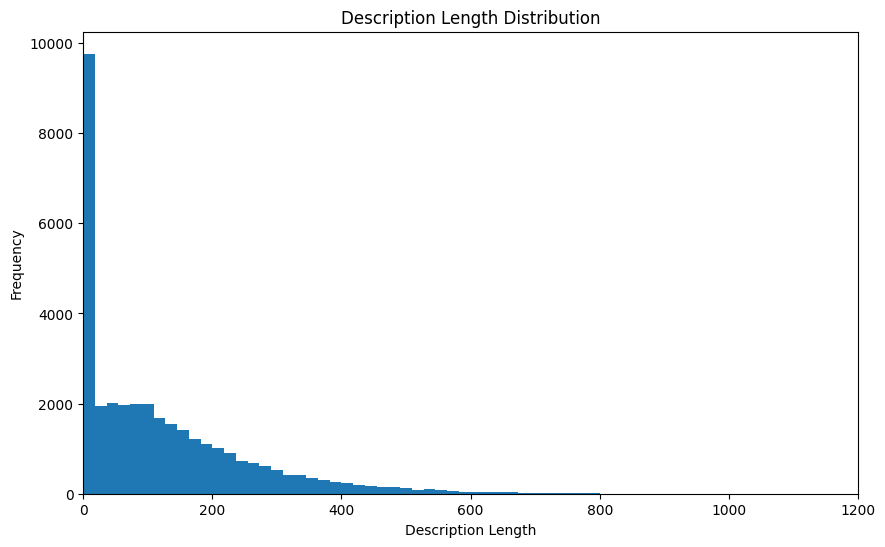

In [111]:
df_lengths = pd.DataFrame(df['Description'].apply(len).values, columns=['description_length'])
#df_lengths['description_length'].describe()
length_distribution = df_lengths['description_length'].value_counts()
plt.figure(figsize=(10,6))
plt.hist(df_lengths['description_length'], bins=50)
plt.xlim([0,1200])
plt.title('Description Length Distribution')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.show()

In [98]:
len(df_lengths[df_lengths['description_length'] > 1200])

215

In [102]:
df_temp = df[df['Description'].apply(len) > 1200].Description
for i, description in df_temp.iteritems():
    print(i)
    print(len(description))
    print(description)
    print('-----')

/var/folders/mq/z3r_z9nd59g6z5rfmlxsltg40000gn/T/ipykernel_36104/2738246511.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, description in df_temp.iteritems():


In [89]:
df_basic.shape

(34532, 432)

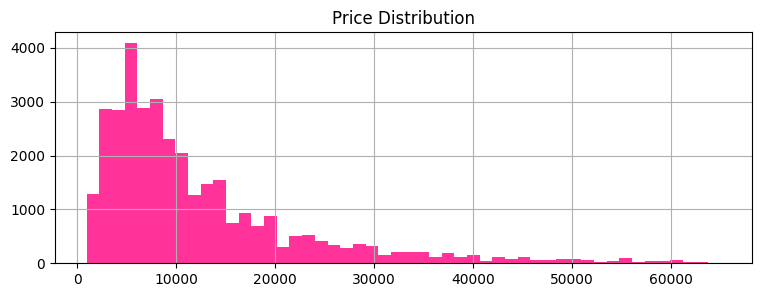

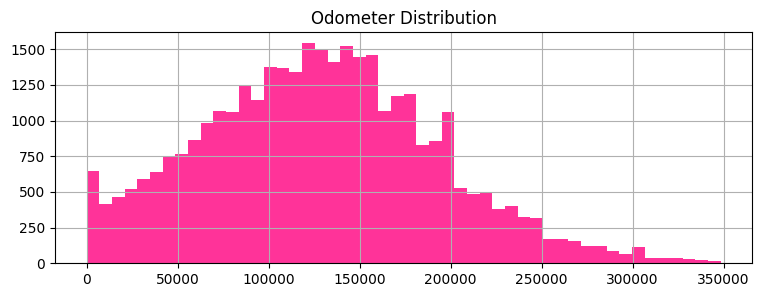

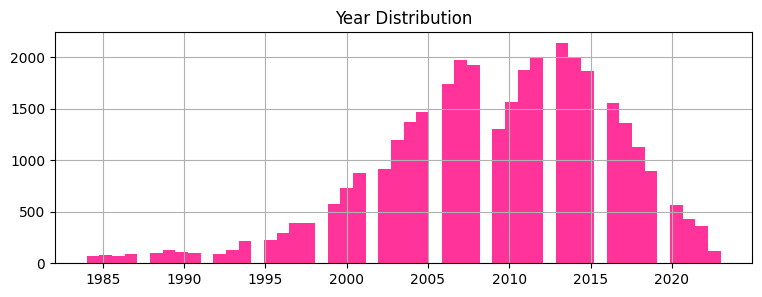

In [114]:
# a different view of the distributions
for i in ["Price", "Odometer","Year"]:
    df[i].hist(bins=50,figsize=(9, 3),color='#FF3399');
    plt.title(i + ' Distribution', loc = 'center');
    plt.show()

## XGBoost + GloVe

checkpoint 0
checkpoint 1
R squared: 0.836


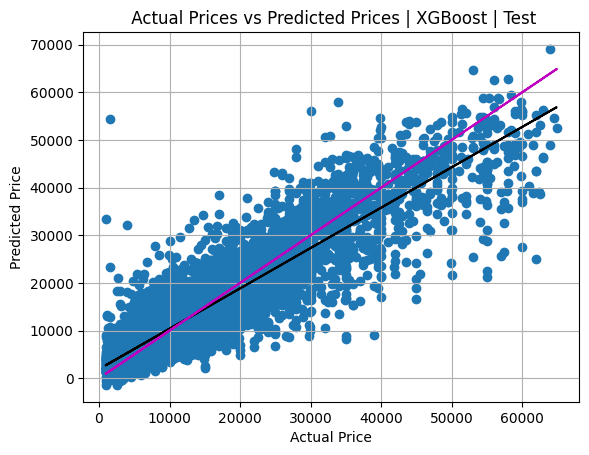

In [119]:
glove_input_file = 'glove.twitter.27B.100d.txt'
#glove_input_file = 'glove.42B.300d.txt'
glove = KeyedVectors.load_word2vec_format(glove_input_file, binary=False, no_header=True)
print('checkpoint 0')

# Function to transform text into a vector
def text_to_vector(text):
    words = text.split()
    word_vectors = [glove[word] for word in words if word in glove.key_to_index]
    return np.mean(word_vectors, axis=0) if len(word_vectors) > 0 else np.zeros(glove.vector_size)

print('checkpoint 1')
# Transform the text data
df_basic_Glove = df_basic.copy()
df_basic_Glove['vector'] = df_basic_Glove['Description'].apply(text_to_vector)
df_basic_Glove = df_basic_Glove.drop(columns = ['Description'])

# Unpack the vector column into separate columns, one for each dimension of the vector
df_vectors = pd.DataFrame(df_basic_Glove['vector'].to_list(), columns=[f'vector_{i}' for i in range(len(df_basic_Glove['vector'][0]))])

# Drop the original vector column
df_basic_Glove.drop(columns=['vector'], inplace=True)

# Concatenate the vector columns back into the original DataFrame
df_basic_Glove = pd.concat([df_basic_Glove, df_vectors], axis=1)

# Split the data into training and test sets
X = df_basic_Glove
y = df_price

test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=0)
bst = XGBRegressor(n_estimators=160,objective='reg:squarederror')
bst.fit(X_train, y_train)

#score = bst.score(X_test, y_test)
y_hat_bst = bst.predict(X_test)

x = y_test; y = y_hat_bst; a, b = np.polyfit(x.Price.values, y, 1); plt.plot(x, a*x+b, '-k'); plt.plot(x, x, '-m')
print("R squared:",round(r2_score(x,y),3));
plt.scatter(x,y); plt.xlabel("Actual Price"); plt.ylabel("Predicted Price");
plt.title(" Actual Prices vs Predicted Prices | XGBoost | Test");plt.grid(); plt.show();

file_path = "/Users/alex/Data_Science/Used_Cars/car_app/xgb_model.pkl"
file_path2 = "xgb_model.pkl"
# save
# pickle.dump(bst, open(file_path, "wb"))
# pickle.dump(bst, open(file_path2, "wb"))


In [95]:
df_basic[df_basic.Make_Volkswagen == 1].columns.tolist()

['Make_Acura',
 'Make_Alfa',
 'Make_Audi',
 'Make_Bmw',
 'Make_Buick',
 'Make_Cadillac',
 'Make_Chevrolet',
 'Make_Chrysler',
 'Make_Dodge',
 'Make_Fiat',
 'Make_Ford',
 'Make_Gmc',
 'Make_Honda',
 'Make_Hummer',
 'Make_Hyundai',
 'Make_Infiniti',
 'Make_Isuzu',
 'Make_Jaguar',
 'Make_Jeep',
 'Make_Kia',
 'Make_Land Rover',
 'Make_Lexus',
 'Make_Lincoln',
 'Make_Maserati',
 'Make_Mazda',
 'Make_Mercedes',
 'Make_Mercury',
 'Make_Mini Cooper',
 'Make_Mitsubishi',
 'Make_Nissan',
 'Make_Oldsmobile',
 'Make_Pontiac',
 'Make_Porsche',
 'Make_Ram',
 'Make_Saab',
 'Make_Saturn',
 'Make_Scion',
 'Make_Smart',
 'Make_Subaru',
 'Make_Tesla',
 'Make_Toyota',
 'Make_Volkswagen',
 'Make_Volvo',
 'Model_128I',
 'Model_200',
 'Model_240',
 'Model_3',
 'Model_300',
 'Model_300Zx',
 'Model_320I',
 'Model_325Ci',
 'Model_325I',
 'Model_328I',
 'Model_328Xi',
 'Model_330Ci',
 'Model_330I',
 'Model_335I',
 'Model_350Z',
 'Model_428I',
 'Model_4Runner',
 'Model_5',
 'Model_500',
 'Model_525I',
 'Model_528

## XGBoost + BERT 

In [43]:
#df_basic = df_basic_old
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def texts_to_vectors(texts):
    print("Starting texts_to_vectors function...")
    
    vectors = []
    for cnt, text in enumerate(texts):
        try:            
            inputs = tokenizer([text], return_tensors="pt", truncation=True, padding=True)
            with torch.no_grad():
                outputs = model(**inputs)
            embeddings = outputs.last_hidden_state
            mask = inputs.attention_mask
            masked_embeddings = embeddings * mask.unsqueeze(-1)
            summed = torch.sum(masked_embeddings, 1)
            summed_mask = torch.clamp(mask.sum(1), min=1e-9)
            mean_pooled = summed / summed_mask.unsqueeze(-1)
            vectors.append(mean_pooled[0].numpy())
        except Exception as e:
            print(f"Error encountered while processing text {cnt}: {e}")
            continue
        # Print progress update every 400 samples
        if cnt % 400 == 0:
            percentage = (cnt / len(texts)) * 100
            print(f"Processing text {cnt} of {len(texts)} ({percentage:.2f}% complete)")
    
    print("Finished converting texts to vectors.")
    return np.array(vectors)

vectors = texts_to_vectors(df_basic['Description'].tolist())
# Unpack the vector column into separate columns, one for each dimension of the vector
df_vectors = pd.DataFrame(vectors, columns=[f'vector_{i}' for i in range(vectors.shape[1])])
# df_vectors.to_csv('df_vectors.csv')

df_basic_bert = df_basic.drop(columns=['Description'])
df_basic_bert = pd.concat([df_basic_bert, df_vectors], axis=1)
df_basic_bert.to_csv('df_basic_bert.csv')
#duplicate important objects to be safe.
vectors_old = vectors
df_vectors_bert = df_vectors

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Starting texts_to_vectors function...
Processing text 0 of 37709 (0.00% complete)
Processing text 400 of 37709 (1.06% complete)
Processing text 800 of 37709 (2.12% complete)
Processing text 1200 of 37709 (3.18% complete)
Processing text 1600 of 37709 (4.24% complete)
Processing text 2000 of 37709 (5.30% complete)
Processing text 2400 of 37709 (6.36% complete)
Processing text 2800 of 37709 (7.43% complete)
Processing text 3200 of 37709 (8.49% complete)
Processing text 3600 of 37709 (9.55% complete)
Processing text 4000 of 37709 (10.61% complete)
Processing text 4400 of 37709 (11.67% complete)
Processing text 4800 of 37709 (12.73% complete)
Processing text 5200 of 37709 (13.79% complete)
Processing text 5600 of 37709 (14.85% complete)
Processing text 6000 of 37709 (15.91% complete)
Processing text 6400 of 37709 (16.97% complete)
Processing text 6800 of 37709 (18.03% complete)
Processing text 7200 of 37709 (19.09% complete)
Processing text 7600 of 37709 (20.15% complete)
Processing text 8

checkpoint 2
checkpoint 3
checkpoint 4
R squared: 0.805


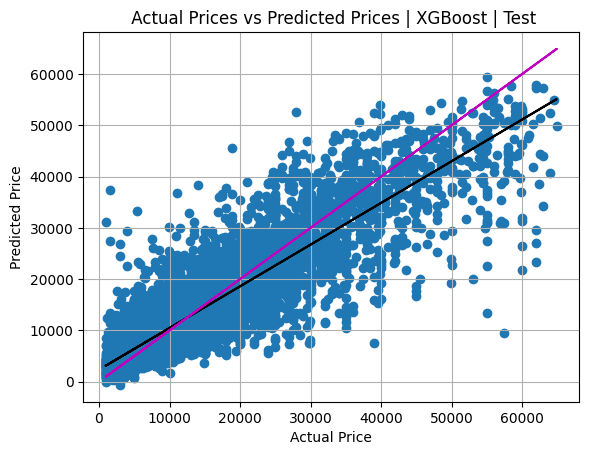

In [23]:
#df_basic = df_basic_bert
#df_basic.drop(columns = ['Description'], inplace = True)
# Split the data into training and test sets
X = df_basic_bert
y = df_price
#y = y.loc[df_basic.index]

test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=0)
print('checkpoint 2')
bst = XGBRegressor(n_estimators=140,objective='reg:squarederror', max_depth = 12)
bst.fit(X_train, y_train)
print('checkpoint 3')

#score = bst.score(X_test, y_test)
y_hat_bst = bst.predict(X_test)
print('checkpoint 4')

x = y_test; y = y_hat_bst; a, b = np.polyfit(x.Price.values, y, 1); plt.plot(x, a*x+b, '-k'); plt.plot(x, x, '-m')
print("R squared:",round(r2_score(x,y),3));
plt.scatter(x,y); plt.xlabel("Actual Price"); plt.ylabel("Predicted Price");
plt.title(" Actual Prices vs Predicted Prices | XGBoost | Test");plt.grid(); plt.show();

file_path = "/Users/alex/Data_Science/Used_Cars/car_app/xgb_model.pkl"
file_path2 = "xgb_model.pkl"
# save
# pickle.dump(bst, open(file_path, "wb"))
# pickle.dump(bst, open(file_path2, "wb"))

From trial and error, it is evident that BERT works better than GloVe. Thus, this is the NLP approach that I will take in conjunction with XGBoost to make the price prediction. 
Steps:
- The text contents of the "Description" column are converted into 768 vectors using PyTorch and BERT
- Those vectors are appended to the original dataframe instead of the textual description. 
- The resulting dataframe is run through XGBRegressor to create a price prediction model. 

In [29]:
file_path = "/Users/alex/Data_Science/Used_Cars/car_app/xgb_model.pkl"
file_path2 = "xgb_model2.pkl"
# save
pickle.dump(bst, open(file_path, "wb"))
pickle.dump(bst, open(file_path2, "wb"))

In [55]:
file_path = "/Users/alex/Data_Science/Used_Cars/car_app/xgb_model.pkl"
file_path2 = "xgb_model.pkl"

# save
pickle.dump(bst, open(file_path, "wb"))
pickle.dump(bst, open(file_path2, "wb"))


Here, I experimented with Principal Component Analysis (PCA) for dimensionality reduction, but ended up not using it as it didn't lead to imporovements in performance.

Number of components that explain at least 95% variance:  150


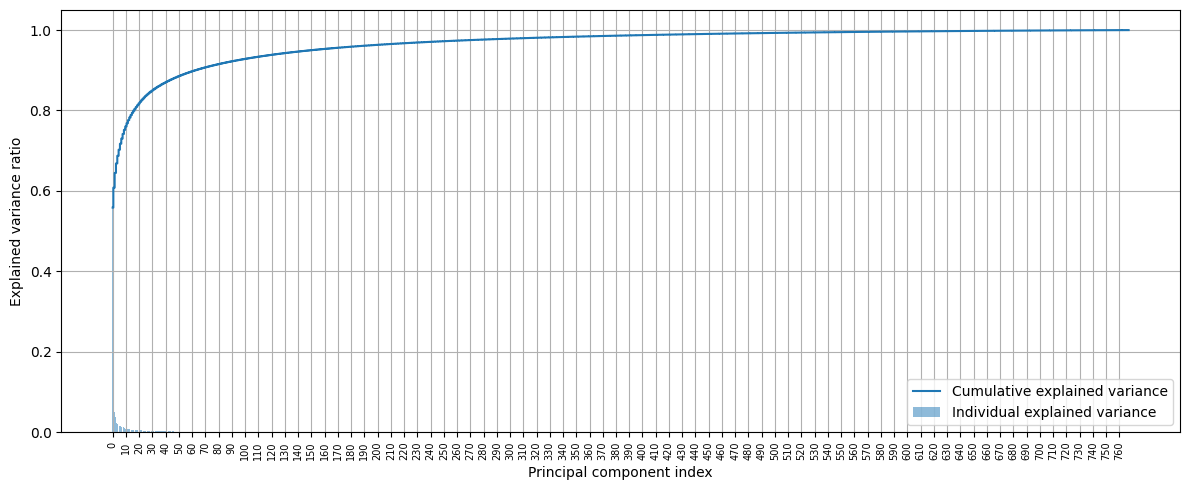

In [240]:
# Scale the dataset; This is very important before you apply PCA
# sc = StandardScaler()
# df_vectors_std = sc.fit_transform(df_vectors)
# Instantiate PCA
pca = PCA()
# Determine transformed features
df_vectors_pca = pca.fit_transform(df_vectors)
# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_
# Identify the number of components that explain 95% of the variance
cumulative_variance_ratio = np.cumsum(exp_var_pca)
n_over_95 = len(cumulative_variance_ratio[cumulative_variance_ratio <= 0.95])
print('Number of components that explain at least 95% variance: ', n_over_95)

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
# Create the visualization plot
fig, ax = plt.subplots(figsize=(12,5))
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
ax.set_xticks(np.arange(0, df_vectors_std.shape[1]+1, 10))
plt.xticks(rotation=90, fontsize=7)
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Prediction Testing

In [ ]:
Make = "Volkswagen"
Model = 'Passat'
Condition = 'Good'
Year = 2012
Odometer = 160000
Drive = 'Fwd'
Fuel = 'Gas'
Title = 'Clean'
Color = 'Green'
Cylinders = '4'
Transmission = "Automatic"

Description = "very good condition."
print(len(Description))
# "very good condition."
# "tires are worn out."
# "check engine light on."

# stop_words = set(stopwords.words('english'))
# def remove_stopwords(description):
#     word_tokens = word_tokenize(description) 
#     filtered_description = [word for word in word_tokens if not word in stop_words] 
#     return ' '.join(filtered_description)

#Description = remove_stopwords(Description)

#conditions = {'New': 5, 'Like New': 4, 'Excellent': 3, 'Good': 2, 'Fair': 1, 'Salvage': 0}
transmission = {'Automatic': 1, 'Manual': 0, 'Other':0}

Description = Description.strip()

def text_to_vector_glove(text):
    words = text.split()
    word_vectors = [glove[word] for word in words if word in glove.key_to_index]
    return np.mean(word_vectors, axis=0) if len(word_vectors) > 0 else np.zeros(glove.vector_size)

def text_to_vector(text):
    inputs = tokenizer([text], return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state
    mask = inputs.attention_mask
    masked_embeddings = embeddings * mask.unsqueeze(-1)
    summed = torch.sum(masked_embeddings, 1)
    summed_mask = torch.clamp(mask.sum(1), min=1e-9)
    mean_pooled = summed / summed_mask.unsqueeze(-1)
    return mean_pooled[0].numpy()

vector = text_to_vector(Description)
frame_vectors = pd.DataFrame([vector], columns=[f'vector_{i}' for i in range(len(vector))])

#df_vectors_std = sc.transform(frame_vectors)
# df_vectors_pca = pca.transform(frame_vectors)
# df_vectors_pca = pd.DataFrame(df_vectors_pca, columns=[f'PC_{i}' for i in range(n_components)])

frame = pd.DataFrame(np.zeros([1,df_info.shape[1]]), columns = df_info.columns).drop(columns = ['Description'])
frame['Make_'+ Make] = 1
frame['Model_'+ Model] = 1
frame['Drive_'+ Drive] = 1
frame['Fuel_'+ Fuel] = 1
frame['Title_'+ Title] = 1
frame['Color_'+ Color] = 1
frame['Condition_' + Condition] = 1
frame['Cylinders_'+ Cylinders] = 1
frame['Year'] = Year
frame['Odometer'] = Odometer
frame['Transmission_Automatic'] = transmission.get(Transmission)
frame = pd.concat([frame, frame_vectors], axis=1)
#frame = pd.concat([frame, df_vectors_pca], axis=1)

print(Description)
print("Price Prediction: $" + str('{:,}'.format(int(bst.predict(frame.values)[0]))))

df_ex = df[(df.Make == Make) & (df.Model == Model) ]#& (df.Condition == Condition) ]#& (df.Year == Year)]# & \
#   (df.Odometer == Odometer) & (df.Year == Year) & (df.Color == Color) & (df.Cylinders == Cylinders)]

display(df_ex.sort_values('Year', ascending = False))



In [277]:
car_makes_models = df_m.Make.unique().tolist() + df_m.Model.unique().tolist()
car_makes_models = [cmm.lower() for cmm in car_makes_models]